### Long Short-Term Memory (LSTM) Network to predict using Mackey-Glass Time series generated data

**Long short-term memory (LSTM)** units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM).

In this notebook the **keras** library is used to implement the LSTM network.

But before doing that, 1000 data points are generated from the Mackey-Glass time series approximation equation.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from seaborn import scatterplot
import pandas as pd
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Activation,Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import variation
from sklearn.metrics import accuracy_score

C:\Users\Ali\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The first 18 data points are provided.

In [2]:
x = [0.96,0.96,0.97,1.00,1.03,1.07,1.10,
     1.13,1.14,1.14,1.13,1.12,1.10,1.09,1.08,1.07,1.07,1.07]

Mackey-Glass differential equation function.

\begin{equation*}
\frac{dx(t)}{dt} = \beta\frac{x(t-\tau)}{1+x^n(t-\tau)} - \gamma x(t)
\end{equation*}

In [3]:
def mg_dfe(x,t):
    gamma = 0.1
    beta = 0.2
    tau = 17
    n = 10
    
    return ((beta*(x[t-tau])/(1+x[t-tau]**n))-gamma*x[t])

Mackey-Glass approximation equation function

\begin{equation*}
x(t+t_1) = x(t) + t_1 \frac {dx(t)} {dt}
\end{equation*}

In [4]:
def get_x(x,t1):
    t = t1-1
    return (x[t] + mg_dfe(x,t))

Generating 982 data points (a total of 1000) from the Mackey-Glass time series

In [5]:
for i in range(1,1001-18):
    x.append(get_x(x,i+17))

Let's plot them out

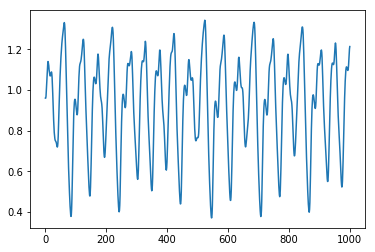

In [6]:
t = range(1,1001)
sns.lineplot(t,x)

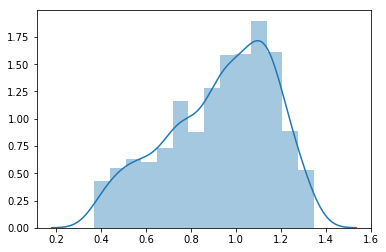

In [7]:
sns.distplot(x)

### Coefficient of Variation (CV) of Test observations

The **coefficient of variation (CV)**, also known as **relative standard deviation (RSD)**, is a standardized measure of dispersion of a probability distribution or frequency distribution. It is often expressed as a percentage, and is defined as the ratio of the standard deviation $\sigma$ to the mean $\mu$.

This will be used to compare the CV for the test predictions to see how close they are.

In [9]:
dfx = pd.DataFrame(x)
print('Coefficient of Variation(CV) or Relative Standard Deviation(RSD) of generated data', variation(dfx[500:]))
dfx.describe()

Coefficient of Variation(CV) or Relative Standard Deviation(RSD) of generated data [0.26273677]


,0
count,1000.000000
mean,0.928002
std,0.236979
min,0.370129
25%,0.759998
50%,0.963779
75%,1.122052
max,1.343574


## LSTM Network for Regression

50% of the generated data will be used to train classifier for prediction.

In [10]:
# fix random seed for reproducibility
np.random.seed(7)

The data should be scaled since LSTMs are sensitive to the scale of the input data.

In [11]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dfx)
print(dataset.shape)

(1000, 1)


The data is split into training and test sets with a ratio of $0.5$.

In [12]:
# split into train and test sets
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

500 500


The following function converts the input array into a dataset with dataX being values at time step (t) and dataY values at time step (t+1). This is necessary since LSTM predicts a value based the previous value.

look_back is the number of previous time steps to use as input variables to predict the next time period (here defaulted to 1).

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Using the above function we reshape the train set.

In [14]:
# reshape into X=t and Y=t+1
look_back = 18
trainX, trainY = create_dataset(train, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

So let's make the necessary changes.

In [15]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

Fit the LSTM network.
Both 'relu' and 'sigmoid' for activation function and 'adam' and 'sgd' for the weight optimizers yield the same result.

In [18]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
 - 8s - loss: 0.0964
Epoch 2/30
 - 4s - loss: 0.0154
Epoch 3/30
 - 4s - loss: 0.0044
Epoch 4/30
 - 4s - loss: 0.0031
Epoch 5/30
 - 4s - loss: 0.0023
Epoch 6/30
 - 4s - loss: 0.0018
Epoch 7/30
 - 4s - loss: 0.0014
Epoch 8/30
 - 4s - loss: 0.0013
Epoch 9/30
 - 4s - loss: 0.0011
Epoch 10/30
 - 4s - loss: 9.3808e-04
Epoch 11/30
 - 4s - loss: 7.8318e-04
Epoch 12/30
 - 4s - loss: 6.8885e-04
Epoch 13/30
 - 4s - loss: 6.9542e-04
Epoch 14/30
 - 4s - loss: 6.1250e-04
Epoch 15/30
 - 4s - loss: 6.9070e-04
Epoch 16/30
 - 4s - loss: 5.5062e-04
Epoch 17/30
 - 4s - loss: 5.2510e-04
Epoch 18/30
 - 4s - loss: 4.4763e-04
Epoch 19/30
 - 4s - loss: 4.6976e-04
Epoch 20/30
 - 4s - loss: 4.0749e-04
Epoch 21/30
 - 4s - loss: 4.1922e-04
Epoch 22/30
 - 4s - loss: 3.7780e-04
Epoch 23/30
 - 4s - loss: 3.7584e-04
Epoch 24/30
 - 4s - loss: 3.2642e-04
Epoch 25/30
 - 4s - loss: 2.8630e-04
Epoch 26/30
 - 4s - loss: 3.1576e-04
Epoch 27/30
 - 5s - loss: 2.5062e-04
Epoch 28/30
 - 4s - loss: 2.7738e-04
Epoch 29/

## Prediction

Predict_test function returns the predictions for data points equivalent to the length of the test set without ever having seen them.

In [27]:
def Predict_test(dataset, look_back=1):
    index = 500
    dummy = []
    setD = dataset[index-look_back:index,0]
    setT = setD
    dummy.append(setD)
    setX = np.array(dummy)
    setX = np.reshape(setX, (setX.shape[0], 1, setX.shape[1]))

    for i in range(0,len(test)):
        dummy = []
        pred = model.predict(setX)
        setT = np.append(setT,(pred[:,0][0]))
        setD = dataset[(index-look_back)+i:index+i,0]
        dummy.append(setD)
        setX = np.array(dummy)
        setX = np.reshape(setX, (setX.shape[0], 1, setX.shape[1]))
    
    return setT

It can be seen that the model perdorms well.

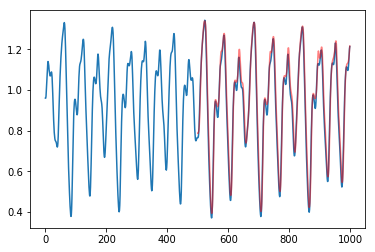

In [35]:
look_back = 18

setT = Predict_test(dataset, look_back)
setT = np.reshape(setT, (setT.shape[0], 1))
setT = scaler.inverse_transform(setT)
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[500:] = setT[18:]
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot, color = 'red', alpha =0.5)

Another way to confirm this is by looking at the coefficient of variation.

Comparing the following CV from the original data and the one for the predicted data:

* Coefficient of Variation(CV) or Relative Standard Deviation(RSD) [0.26273677]

They are quite the same.

In [31]:
print('Coefficient of Variation(CV) or Relative Standard Deviation(RSD) of test data', variation(setT[:,0]))

Coefficient of Variation(CV) or Relative Standard Deviation(RSD) of test data 0.25564261655142156
